In [51]:
import numpy as np
import pandas as pd
import torch

In [52]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [53]:
data = pd.read_csv("consumer_complaints.csv")

print(data.shape)
data.head()

(555957, 18)


/tmp/ipykernel_5107/3115789634.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("consumer_complaints.csv")


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [54]:
data.dropna(subset=["consumer_complaint_narrative", "product"], inplace=True)
data.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
190126,03/19/2015,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,NaN,"Diversified Consultants, Inc.",NY,121XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290516
190135,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,Due to inconsistencies in the amount owed that...,NaN,M&T Bank Corporation,VA,221XX,Servicemember,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290492
190155,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,In XX/XX/XXXX my wages that I earned at my job...,NaN,Wells Fargo & Company,CA,946XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524
190207,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,I have an open and current mortgage with Chase...,NaN,JPMorgan Chase & Co.,CA,900XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290253
190208,03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,NaN,XXXX was submitted XX/XX/XXXX. At the time I s...,NaN,Rushmore Loan Management Services LLC,CA,956XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1292137


In [55]:
data['word_count'] = data['consumer_complaint_narrative'].str.split().str.len()
data = data[data['word_count'] >= 250][["product", "consumer_complaint_narrative"]]

print(data.shape)
data.head()

(17142, 2)


,product,consumer_complaint_narrative
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...
190251,Mortgage,I spoke to XXXX of green tree representatives ...
190263,Credit card,i opened XXXX Bank of America credit cards 15-...
190264,Consumer Loan,I applied for a loan with XXXX XXXX and had pu...


In [56]:
data["product"].value_counts()

Mortgage                   6042
Debt collection            2832
Credit card                2293
Bank account or service    1930
Credit reporting           1753
Consumer Loan              1066
Student loan                734
Money transfers             201
Prepaid card                160
Payday loan                 100
Other financial service      31
Name: product, dtype: int64

In [57]:
data = data[~data["product"].isin(["Other financial service"])]

In [58]:
num_labels = len(data["product"].unique())
print("num labels: ", num_labels)
genre2id = {genre: i for i, genre in enumerate(data["product"].unique())}
id2genre = {i: genre for i, genre in enumerate(data["product"].unique())}

num labels:  10


In [59]:
data["genre_id"] = data["product"].apply(lambda a: genre2id[a])

In [60]:
import re

def clean_text(text):
    text = re.sub('[^a-zA-Z0-9\.\,\?\!]', ' ', str(text).lower()) # remove all except lowercase, uppercase, digits, punctuation
    text = re.sub('\[.*?\]', '', text) # remove any text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove any links present 
    text = re.sub('\n', ' ', text) # remove the next line character
    text = re.sub('\w*\d\w*', '', text) # remove the words contaitning numbers
    text = re.sub('\s+', ' ', text) # remove extra spaces
    text = re.sub('x{2,}', '', text) # remove multiple x's
    
    return text

In [61]:
data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(clean_text)
data.head()

,product,consumer_complaint_narrative,genre_id
190155,Mortgage,in my wages that i earned at my job decreas...,0
190208,Mortgage,was submitted . at the time i submitted thi...,0
190251,Mortgage,i spoke to of green tree representatives on ...,0
190263,Credit card,i opened bank of america credit cards years a...,1
190264,Consumer Loan,i applied for a loan with and had purchased ...,2


In [62]:
mortgage = data[data["genre_id"] == 0]
credit_card = data[data["genre_id"] == 1]
consumer_loan = data[data["genre_id"] == 2]
debt_collection = data[data["genre_id"] == 3]
credit_reporting = data[data["genre_id"] == 4]
student_loan = data[data["genre_id"] == 5]
bank_account = data[data["genre_id"] == 6]
money_transfers = data[data["genre_id"] == 7]
payday_loan = data[data["genre_id"] == 8]
prepaid_card = data[data["genre_id"] == 9]

In [63]:
from sklearn.utils import resample

mortgage_downsample = resample(mortgage,
                              replace=False,
                              n_samples=600,
                              random_state=42)

credit_card_downsample = resample(credit_card,
                              replace=False,
                              n_samples=600,
                              random_state=42)

consumer_loan_downsample = resample(consumer_loan,
                              replace=False,
                              n_samples=600,
                              random_state=42)

debt_collection_downsample = resample(debt_collection,
                              replace=False,
                              n_samples=600,
                              random_state=42)

credit_reporting_downsample = resample(credit_reporting,
                              replace=False,
                              n_samples=600,
                              random_state=42)

student_loan_downsample = resample(student_loan,
                              replace=False,
                              n_samples=500,
                              random_state=42)

bank_account_downsample = resample(bank_account,
                              replace=False,
                              n_samples=600,
                              random_state=42)

money_transfers_downsample = resample(money_transfers,
                              replace=False,
                              n_samples=160,
                              random_state=42)

payday_loan_downsample = resample(payday_loan,
                              replace=False,
                              n_samples=80,
                              random_state=42)

prepaid_card_downsample = resample(prepaid_card,
                              replace=False,
                              n_samples=130,
                              random_state=42)

In [64]:
train = pd.concat([mortgage_downsample, credit_card_downsample, consumer_loan_downsample, debt_collection_downsample, credit_reporting_downsample, student_loan_downsample, bank_account_downsample, money_transfers_downsample, payday_loan_downsample, prepaid_card_downsample])

In [65]:
train["product"].value_counts()

Mortgage                   600
Credit card                600
Consumer Loan              600
Debt collection            600
Credit reporting           600
Bank account or service    600
Student loan               500
Money transfers            160
Prepaid card               130
Payday loan                 80
Name: product, dtype: int64

In [66]:
test = data.loc[~data.index.isin(train.index)]

In [67]:
test["product"].value_counts()

Mortgage                   5442
Debt collection            2232
Credit card                1693
Bank account or service    1330
Credit reporting           1153
Consumer Loan               466
Student loan                234
Money transfers              41
Prepaid card                 30
Payday loan                  20
Name: product, dtype: int64

In [68]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1070


In [69]:
train

,product,consumer_complaint_narrative,genre_id
289175,Mortgage,we have been trying to get our home out of for...,0
255512,Mortgage,carrington mortgage took over servicing my loa...,0
504921,Mortgage,this is a dispute to case number . i received ...,0
297108,Mortgage,"is to any ? dear .... my name is , with ...",0
312177,Mortgage,", i took out a mortgage . less than a month ...",0
...,...,...,...
224279,Prepaid card,i signed up for pay power visa card to get a ...,9
245873,Prepaid card,i purchased goggle . gift cards and when i we...,9
297169,Prepaid card,"on , i was online trying to file for identity...",9
519629,Prepaid card,on i noticed some suspicious activity on my ...,9


# Now we are going use Test rank to summarize all the consumer_complaint_narrative that is more than 512 tokens.

In [40]:
import spacy
import pytextrank

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textrank")
def summarize(input_text: str, max_tokens: int = 512):
    # Load a SpaCy model. For example, the English model.


    # Parse the document with SpaCy.
    doc = nlp(input_text)

    # If the text is less than 512 words, return the original text.
    if len(doc) <= max_tokens:
        return input_text

    # Extract the phrases using TextRank.
    phrases = ", ".join([p.text for p in doc._.phrases])

    summarized_doc = []  # Initialize an empty list to store the summarized sentences

    # Iterate over the sentences generated by textrank.summary and append them to the list
    for sent in doc._.textrank.summary(limit_sentences=50):
        summarized_doc.append(sent)


    # Join the sentences to form the summary.
    summary = " ".join([span.text for span in summarized_doc])

    # If the summary is longer than max_tokens, truncate it.
    if len(summary.split()) > max_tokens:
        summary = " ".join(summary.split()[:max_tokens])

    return summary



In [43]:
print("\n-----------------------before TextRank---------------------\n")


print(train["consumer_complaint_narrative"][297108])
print("\n-----------------------Progressing---------------------\n")
try:
    train["consumer_complaint_narrative"] = train["consumer_complaint_narrative"].apply(summarize)
    test["consumer_complaint_narrative"] = test["consumer_complaint_narrative"].apply(summarize)
except Exception as e:
    print("An error occurred while applying text_rank:", str(e))
    
print(train["consumer_complaint_narrative"][297108])
print("\n-----------------------after TextRank---------------------\n")


-----------------------before TextRank---------------------

i stared a loan modification with the loan servicer on with a trial payments, and , after a payment was made, i received a loan modification agreement. when i was n t the party who was late in the process as it recognized by , consumer account analyst from the office of the consumer ombudsman at ocwen loan servicing in a after been talking with the relationship manager about it, he says the same, the loan modification was n t complete but i never received a letter from the servicer explaining that they are behind in the process but the loan modification is approved until or , i do n t exactly remember, when i spoke with the relationship manager and he told me that everything is approved few days after, i received a loan statement showing month behind, date . the loan documents will be modified and the first modified payment will be due on gt , when i tried to make the mortgage payment as stipulated on the loan agreement, the

KeyboardInterrupt: 

# Now we couldtrain the model

In [70]:
train_summary = train.consumer_complaint_narrative.values
train_labels = train.genre_id.values

test_summary = test.consumer_complaint_narrative.values
test_labels = test.genre_id.values

In [71]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, BertTokenizer

# Create a tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# Tokenize the text
def tokenize_text(summary, max_length=512):
    # Tokenize the 'summary' column of the DataFrame using the tokenizer's batch_encode_plus method
    # df['summary'].tolist() converts the 'summary' column into a list of strings
    # max_length specifies the maximum length of the tokenized sequences
    # padding='max_length' pads the tokenized sequences to have a length of max_length
    # truncation=True truncates the tokenized sequences if they exceed the max_length
    return tokenizer.batch_encode_plus(
        summary.tolist(), 
        max_length=max_length, 
        padding='max_length', 
        truncation=True
    )

tokenized_train_texts = tokenize_text(train_summary)
tokenized_test_texts = tokenize_text(test_summary)

In [72]:
#Then prepare the dataset and dataloader
from torch.utils.data import Dataset, DataLoader

class BookDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create the dataset
train_dataset = BookDataset(tokenized_train_texts, train['genre_id'].values)
test_dataset = BookDataset(tokenized_test_texts, test['genre_id'].values)

# Create the dataloader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [73]:
from transformers import BertTokenizer, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train['genre_id'].unique()))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Starting epoch 0


Training: 100%|███████████████████████████████| 559/559 [07:29<00:00,  1.24it/s]


Saved checkpoint for epoch 0.


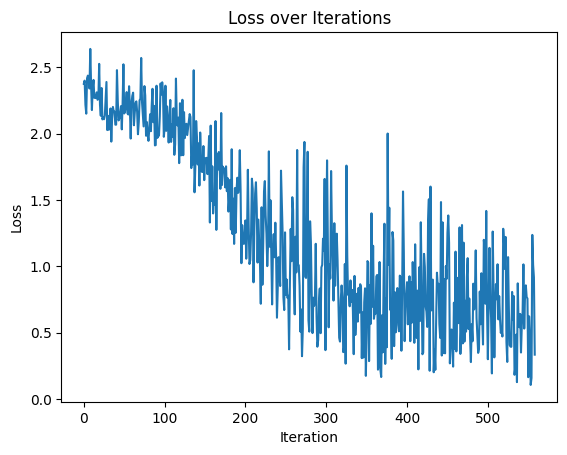

Starting epoch 1


Training: 100%|███████████████████████████████| 559/559 [07:32<00:00,  1.23it/s]


Saved checkpoint for epoch 1.


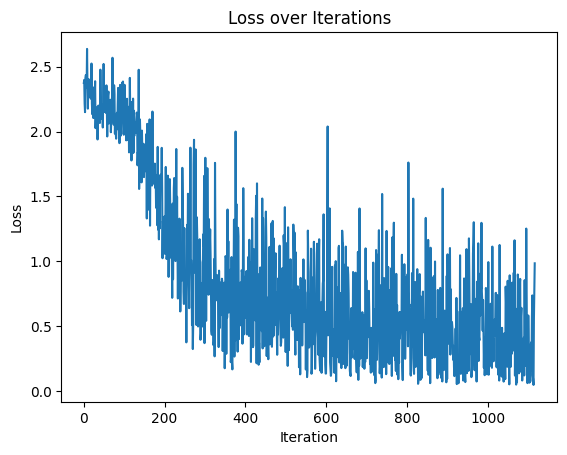

Starting epoch 2


Training: 100%|███████████████████████████████| 559/559 [07:32<00:00,  1.23it/s]


Saved checkpoint for epoch 2.


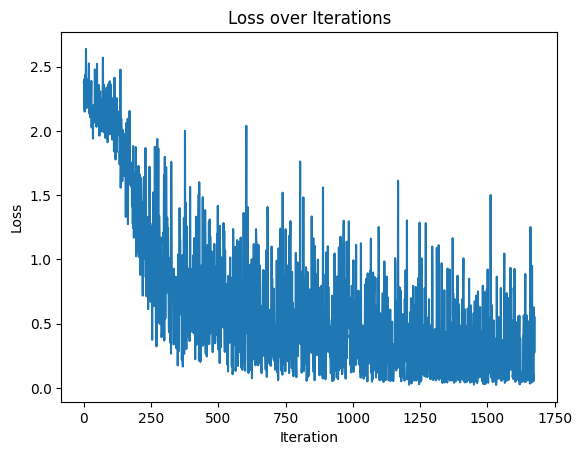

Starting epoch 3


Training: 100%|███████████████████████████████| 559/559 [07:32<00:00,  1.23it/s]


Saved checkpoint for epoch 3.


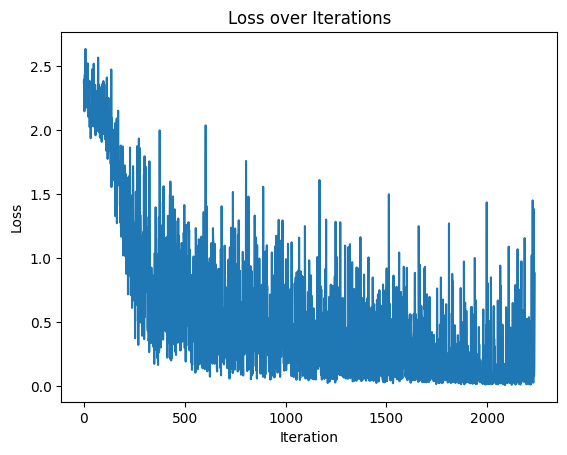

In [74]:
from torch.optim import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torch

# Initialize the optimizer
optimizer = Adam(model.parameters(), lr=2e-5)

# Move the model to the GPU
model.train()
model.to('cuda')

# Initialize a list to store the loss values
losses = []

checkpoint_path = "model2_no_textrank.pth"  # Change to your preferred location

start_epoch = 0

# Load from checkpoint if it exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    losses = checkpoint['losses']
    print("Loaded checkpoint.")

# Training 
for epoch in range(start_epoch, 4):
    print(f"Starting epoch {epoch}")
    for batch in tqdm(train_dataloader, desc="Training"):
        batch = {k: v.to('cuda') for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        # Optimize the model parameters
        optimizer.step()
        optimizer.zero_grad()

        # Append the loss value to the list
        losses.append(loss.item())  

    # Save checkpoint after each epoch
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
    }, checkpoint_path)
    print(f"Saved checkpoint for epoch {epoch}.")

    # Plot the loss values after each epoch
    plt.plot(losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss over Iterations')
    plt.show()


In [78]:
#Load the model
checkpoint_path = "model2_with_textrank.pth"  # Change to your preferred location
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    losses = checkpoint['losses']
    print("Loaded checkpoint.")

Loaded checkpoint.


# Evaluate it:

In [79]:
model.eval()
model.to('cuda')
predictions = []
true_labels = []

# Iterate over the test dataset
for batch in test_dataloader:
    batch = {k: v.to('cuda') for k, v in batch.items()}

    # Disable gradient calculation
    with torch.no_grad():
        # Perform inference
        outputs = model(**batch)
        
    predicted_values = outputs.logits
    predictions.extend(predicted_values)
    true_labels.extend(batch['labels'].tolist())

# Convert logits to predictions
predictions = [torch.argmax(item).item() for item in predictions]

# Make sure that true_labels is a list
assert isinstance(true_labels, list)

from sklearn.metrics import classification_report


# Generate classification report
report = classification_report(true_labels, predictions)

print(report)

# Save the report to a file
with open('classification_report_for_model2_with_textrank.txt', 'w') as file:
    file.write(report)


              precision    recall  f1-score   support

           0       0.97      0.96      0.96      5442
           1       0.90      0.74      0.81      1693
           2       0.55      0.84      0.67       466
           3       0.89      0.79      0.84      2232
           4       0.91      0.88      0.90      1153
           5       0.77      0.93      0.84       234
           6       0.75      0.86      0.80      1330
           7       0.20      0.83      0.33        41
           8       0.24      0.35      0.29        20
           9       0.42      0.83      0.56        30

    accuracy                           0.87     12641
   macro avg       0.66      0.80      0.70     12641
weighted avg       0.89      0.87      0.88     12641

